## Purpose: simple problem with errors in both x and y.

In problems with errors in xdata and ydata the positions of all the xdata need to be optimized too. So we have an extra set of parameters that not actually are part of the model to be fitted. These kind of parameters are called nuisance parameters. 

These kind of problems can be solved with NestedSampler using the ErrorsInXandYProblem in stead of the default ClassicProblem.

Gull (1989) proved that for linear models the optimal solution is found by minimizing the perpendicular distances of the datapoints to the line.

Demonstration: 
1. Linear Model of artificial data
2. Parameter fit with errors in x and y

Author: Do Kester


Import classes

In [1]:
import numpy as numpy
import math

from BayesicFitting import PolynomialModel

from BayesicFitting import NestedSampler
from BayesicFitting import ErrorsInXandYProblem
from BayesicFitting import GaussPrior
from BayesicFitting import UniformPrior
from BayesicFitting import LaplacePrior
from BayesicFitting import Tools
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#%matplotlib osx

Define the constants of the linear relation. 

In [2]:
# define some constants
N = 41
b0 = 0.2            # offset of background
b1 = 0.5            # slope of background

sig = 0.5

Make a 1st-degree polynomial

In [3]:
xm = numpy.linspace( -2.0, 5.0, N, dtype=float )
ym = b0 + b1 * xm

numpy.random.seed( 1308 )
y = ym + sig * numpy.random.randn( N )
x = xm + sig * numpy.random.randn( N )

Define the model and define the limits on the model parameters

In [4]:
mdl = PolynomialModel( 2 )
mdl.setLimits( -10, 10 )


We need to set a specific Problem in this case: ErrorsInXandYProblem. It adds N extra parameters to the list, one for each datapoint present. These extra (nuisance) parameters need Priors. The same Prior for all, but centered on each of the x-points. 
[Gull (1989)](https://bayes.wustl.edu/sfg/line.pdf) argues for a Gaussian prior with a sigma about the same size as in the error distribution. 


The ErrorsInXandYProblem automatically enlists both the GalileanEngine and the GibbsEngine. The latter might be more efficient in moving the extra parameters around. They are all independent of each other and GibbsEngine tries to move the parameters one at a time.

In [5]:
#prior = LaplacePrior(  )
prior = UniformPrior( limits=[-3,3] )
problem = ErrorsInXandYProblem( mdl, x, y, prior=prior )

Invoke the NestedSampler with the problem just instantiated. The limits in the initialisation of NS are passed to the (Jeffreys)Prior of the scale hyperparameter in the (Gauss)Errordistribution. 
We want to do an extra long run as at the default end (=2.0) the information, H, is not yet completely stabilised.

In [6]:
ns = NestedSampler( problem=problem, limits=[0.1,1] )

# extra long run.
ns.end = 3.0

# find the solution
evid = ns.sample( )


Fit all parameters of
  Polynomial: f( x:p ) = p_0 + p_1 * x + p_2 * x^2
Using a Gauss2d error distribution with unknown scale
Moving the walkers with   GalileanEngine  GibbsEngine  ChordEngine
>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>

>

>

>

>

>

>


Iteration   logZ        H     LowL     npar    parameters
   21108      -90.1     70.4       17.7     45 
[    0.181    0.436    0.003   -1.875   -2.053   -1.518   -1.690   -0.698   -0.305   -1.065   -0.882   -0.845   -0.086
    -0.116   -0.351   -0.472    0.045    0.109    0.169    0.943    0.666    1.088    0.405    1.205    1.255    2.365
     1.639    2.387    2.958    3.190    2.554    2.616    4.255    2.867    3.474    4.112    4.139    4.264    3.997
     5.254    3.899    4.505    5.190    4.912    0.307]
Engines              success     reject     failed       best      calls
GalileanEngine         75932      53884     113152          0      21108
GibbsEngine          1711040    2460870     188680          0      21108
ChordEngine           147773     745081          1          0      21108
Calls to LogL        5496413   to dLogL      53884
Samples       21208
Evidence       -39.145 +-      0.364


In [7]:
pars = ns.parameters
print( "Parameters :", fmt( pars, max=None ) )
print( "StDevs     :", fmt( ns.stdevs, max=10 ) )
xopt = ns.samples.nuisance
print( "xdata      :", fmt( x, max=10))
print( "Nuisance   :", fmt( xopt, max=10 ) )
print( "StdevNuis  :", fmt( ns.samples.stdevNuis, max=10 ))
print( "Scale      :", fmt( ns.scale ) )


Parameters : [    0.200    0.423    0.002]
StDevs     : [    0.115    0.074    0.019]


xdata      : [   -1.953   -1.940   -1.452   -1.827   -0.923   -0.399   -1.018   -0.677   -0.680   -0.118 ...]
Nuisance   : [   -1.925   -2.065   -1.536   -1.659   -0.714   -0.340   -1.059   -0.931   -0.857   -0.145 ...]
StdevNuis  : [    0.494    0.489    0.479    0.494    0.480    0.478    0.482    0.478    0.491    0.481 ...]
Scale      :     0.491


Plot the line and the connections of the datapoints to their targets.
Note that the axes are scaled to the same size to show that the distances are perpendicular (more or less).

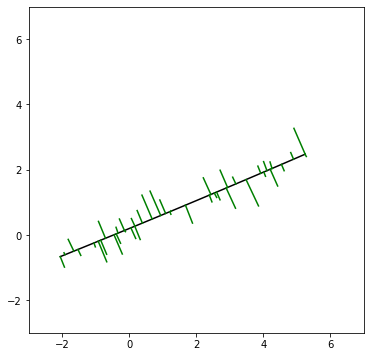

In [8]:
xx = numpy.linspace( min(xopt), max(xopt), 101 )

yfit = mdl.result( xx, pars )
plt.figure( "Errors in X and Y", figsize=(6,6) )

plt.plot( xx, yfit, 'k-' )
yopt = mdl.result( xopt, pars )
#plt.plot( xopt, yopt, 'k-' )
for k in range( N ):
    plt.plot( [x[k],xopt[k]], [y[k],yopt[k]], 'g-')
plt.axis( [-3.0, 7.0, -3.0, 7.0] )
    
plt.show()